In [1]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, qeye, tensor
import matplotlib.pyplot as plt
import pennylane as qml
from skopt import gp_minimize
from skopt.space import Real
import sobol_seq  
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import logging
import pickle
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp

In [2]:
def heisenberg_hamiltonian(N, J1, indx1):
    """Constructs the sparse Heisenberg Hamiltonian for N spins."""
    
    H = None  # Initialize Hamiltonian
    
    Sx, Sy, Sz = sigmax(), sigmay(), sigmaz()
    I = qeye(2)  # Identity matrix for a single spin

    for i in range(N):
        for j in range(i + 1, N):  # Avoid double counting
            
            if indx1[i, j]:  # Nearest-neighbor interaction
                term = J1[0] * tensor(*[Sx if k in (i, j) else I for k in range(N)]) + \
                       J1[1] * tensor(*[Sy if k in (i, j) else I for k in range(N)]) + \
                       J1[2] * tensor(*[Sz if k in (i, j) else I for k in range(N)])
                H = term if H is None else H + term

    return H

def zeeman_hamiltonian(N, B):
    """Constructs the sparse Zeeman Hamiltonian for N spins."""
    
    Hz = None  

    Sx, Sy, Sz = sigmax(), sigmay(), sigmaz()
    I = qeye(2)  

    for i in range(N):
        term = B[0] * tensor(*[Sx if k == i else I for k in range(N)]) + \
               B[1] * tensor(*[Sy if k == i else I for k in range(N)]) + \
               B[2] * tensor(*[Sz if k == i else I for k in range(N)])
        Hz = term if Hz is None else Hz + term

    return Hz

def find_ground_state(N, J1, indx1, B):
    """Computes the ground state and energy using sparse methods."""
    
    H = heisenberg_hamiltonian(N, J1, indx1) + zeeman_hamiltonian(N, B)
    
    # Convert to SciPy sparse matrix
    H_sparse = H.data.as_scipy()  # Convert to SciPy sparse format

    # Compute only the lowest eigenvalue and eigenvector using a sparse solver
    eigenvalues, eigenvectors = eigsh(H_sparse, k=1, which="SA")  # Smallest eigenvalue

    ground_energy = eigenvalues[0]
    ground_state = eigenvectors[:, 0]  # First column is the ground state

    return ground_state, ground_energy


In [3]:
def get_lattice_indices(M, N):
    num_sites = M * N
    indx1 = np.zeros((num_sites, num_sites), dtype=int)
    indx2 = np.zeros((num_sites, num_sites), dtype=int)
    
    def site_index(row, col):
        return (row % M) * N + (col % N)  # Periodic boundary conditions
    
    for row in range(M):
        for col in range(N):
            i = site_index(row, col)
            
            # Nearest neighbors
            neighbors = [
                (row + 1, col),  # Down
                (row - 1, col),  # Up
                (row, col + 1),  # Right
                (row, col - 1)   # Left
            ]
            
            for r, c in neighbors:
                j = site_index(r, c)
                if i != j:  # Avoid self-interaction
                    indx1[i, j] = 1
                
            # Next-nearest neighbors (diagonals)
            diag_neighbors = [
                (row + 1, col + 1),  # Down-Right
                (row + 1, col - 1),  # Down-Left
                (row - 1, col + 1),  # Up-Right
                (row - 1, col - 1)   # Up-Left
            ]
            
            for r, c in diag_neighbors:
                j = site_index(r, c)
                if i != j:  # Avoid self-interaction
                    indx2[i, j] = 1
    
    return indx1, indx2

In [4]:
# Sobol sequence sampler for better parameter initialization
def sobol_sampler(dim, num_samples):
    samples = sobol_seq.i4_sobol_generate(dim, num_samples)  # Generate Sobol sequence
    return samples * 2 * np.pi  # Scale to [0, 2π] range

# Step 1: Monte Carlo Search (Global Exploration)
def monte_carlo_search(psi, num_params, num_samples, overlap_func):
    sobol_samples = sobol_sampler(num_params, num_samples)  # Generate Sobol sequence

    def evaluate_sample(params):
        return overlap_func(psi, *params)  # Explicitly use the passed overlap function

    # Run sequentially for debugging (use ProcessPoolExecutor for parallelism)
    overlaps = [evaluate_sample(params) for params in sobol_samples]

    best_idx = np.argmin(overlaps)  # Get index of best candidate
    return sobol_samples[best_idx]  # Return best parameter set


def refine_with_gradient(psi, initial_guess, overlap_func, method="BFGS"):
    result = minimize(
        lambda params: overlap_func(psi, *params),  # Explicitly pass overlap function
        initial_guess,
        method=method
    )
    return result.fun, result.x  # Return best GE and optimized parameters

def hybrid_optimization(psi, num_params, num_samples, overlap_func):
    best_mc_guess = monte_carlo_search(psi, num_params, num_samples, overlap_func)  # Pass function
    best_GE, best_params = refine_with_gradient(psi, best_mc_guess, overlap_func)  # Pass function
    return best_GE, best_params


In [5]:
# Define the custom two-qubit operation
def custom_two_qubit_operation(wires, c1, c2, c3):
    control, target = wires  # Extract control and target qubit indices

    # Entangling operation sequence
    qml.CNOT(wires=[control, target])
    qml.RX(c1, wires=target)
    qml.CNOT(wires=[control, target])
    qml.CNOT(wires=[target, control])
    qml.RZ(c3, wires=target)
    qml.CNOT(wires=[target, control])
    qml.CY(wires=[control, target])
    qml.RY(c2, wires=target)
    qml.CY(wires=[control, target])


# Define the quantum device
def create_device(N):
    return qml.device("default.qubit", wires=N)

# Define the bipartite circuit
def create_qnode(N):
    dev = create_device(N)

    @qml.qnode(dev)
    def circuit(phi1, beta1, phi2, beta2): # the ring is partitioned into pairs of qubits
        # Partition the qubits into even and odd sets
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}
        
        # Apply RX rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RX(phi1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RX(phi2, wires=odd_indices[i])


        # Apply RZ rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RZ(beta1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RZ(beta2, wires=odd_indices[i])

        return qml.state()  # Return state vector
    
    
    @qml.qnode(dev)
    def circuit_row(phi1, beta1, phi2, beta2, c1, c2, c3, rows, cols): 
        N1 = cols  # Number of columns (qubits per row)
        M1 = rows  # Number of rows

        # Partition qubits into even and odd indices
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}

        # Apply RX rotation to all qubits
        for i in even_indices:
            qml.RX(phi1, wires=i)
        for i in odd_indices:
            qml.RX(phi2, wires=i)

        # Construct site index mapping
        site_index = [[(row % M1) * N1 + (col % N1) for col in range(N1)] for row in range(M1)]     

        # Apply custom operation to pairs in the even set
        for i in range(M1):  # rows is an integer
            for j in range(N1 - 1):  # Iterate properly over column indices
                wires = [site_index[i][j], site_index[i][j + 1]]  # Use correct indexing
                custom_two_qubit_operation(wires, c1, c2, c3)   

        # Apply RZ rotation to all qubits
        for i in even_indices:
            qml.RZ(beta1, wires=i)
        for i in odd_indices:
            qml.RZ(beta2, wires=i)

        return qml.state()  # Return state vector
    
    @qml.qnode(dev)
    def circuit_col(phi1, beta1, phi2, beta2, c1, c2, c3, rows, cols): #not col but unconventional 
        N1 = cols  # Number of columns (qubits per row)
        M1 = rows  # Number of rows

        # Partition qubits into even and odd indices
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}

        # Apply RX rotation to all qubits
        for i in even_indices:
            qml.RX(phi1, wires=i)
        for i in odd_indices:
            qml.RX(phi2, wires=i)

        # Construct site index mapping
        site_index = [[0,3,12,15],[1,2,13,14],[4,7,8,11],[5,6,9,10]]     

        # Apply custom operation to pairs in the even set
        for i in range(N1):  # rows is an integer
            for j in range(M1 - 1):  # Iterate properly over column indices
                wires = [site_index[i][j], site_index[i][j+1]]  # Use correct indexing
                custom_two_qubit_operation(wires, c1, c2, c3)   

        # Apply RZ rotation to all qubits
        for i in even_indices:
            qml.RZ(beta1, wires=i)
        for i in odd_indices:
            qml.RZ(beta2, wires=i)

        return qml.state()  # Return state vector
    
    @qml.qnode(dev)
    def circuit_EO(phi1, beta1, phi2, beta2, c1, c2, c3, rows, cols): #not col but unconventional 
        N1 = cols  # Number of columns (qubits per row)
        M1 = rows  # Number of rows

        # Partition qubits into even and odd indices
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}

        # Apply RX rotation to all qubits
        for i in even_indices:
            qml.RX(phi1, wires=i)
        for i in odd_indices:
            qml.RX(phi2, wires=i)

        # Construct site index mapping
        site_index = [[0,2,4,6,8,10],[1,3,5,7,9,11]]
        M11, N11=len(site_index), len(site_index[0])

        # Apply custom operation to pairs in the even set
        for i in range(M11):  # rows is an integer
            for j in range(N11-1):  # Iterate properly over column indices
                wires = [site_index[i][j], site_index[i][j+1]]  # Use correct indexing
                custom_two_qubit_operation(wires, c1, c2, c3)   

        # Apply RZ rotation to all qubits
        for i in even_indices:
            qml.RZ(beta1, wires=i)
        for i in odd_indices:
            qml.RZ(beta2, wires=i)

        return qml.state()  # Return state vector

    return circuit, circuit_row, circuit_col, circuit_EO

In [6]:
# Finding ground state
# Target ground state for N number of spins
def GS_p(p,d, M1, N1):
    J=0.25
    J1 = np.array([J, J,J* d])  # nearest-neighbor coupling constant
    B=np.array([0, 0,-p])
    indx1, indx2 = get_lattice_indices(M1, N1)
    N = M1 * N1 # Number of spins

    # Find ground state and energy
    ground_state, ground_energy = find_ground_state(N, J1, indx1, B)

    ground_state = ground_state.flatten()
    return ground_state

# Evaluate GE for a range of p values
p_values = np.linspace(-5, 5, 24)

# Ensure -1 and 1 are included
required_values = {-1, 1}
p_values = np.unique(np.append(p_values, list(required_values)))  # Add and remove duplicates

# Sort the array
p_values.sort()

MR=4# Number of rows
NC=4 # Number of columns
NS=MR*NC
psis0 = [GS_p(p, 2, MR, NC) for p in p_values]  # d=2 isotropic XY (or XX) model
psis1 = [GS_p(p, 1.5, MR, NC) for p in p_values]  # d=1.5 ising model
psishalf = [GS_p(p, 1, MR, NC) for p in p_values]  # d=1 XY  model


In [7]:
# Save to a file using pickle
with open('dataXXZ2D16hne0.pkl', 'wb') as f:
    pickle.dump({'p_values': p_values, 'psis0': psis0, 'psis1': psis1, 'psishalf': psishalf}, f)

In [8]:
# Load the data from the file
with open('dataXXZ2D16hne0.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert the lists to NumPy arrays
p_values=np.array(data['p_values'])
psis0 = np.array(data['psis0'])
psis1 = np.array(data['psis1'])
psishalf = np.array(data['psishalf'])

print(psis0.shape)

print(p_values)
print(psis0[0])
print(psis1[0])
print(psishalf[0])

(26, 65536)
[-5.         -4.56521739 -4.13043478 -3.69565217 -3.26086957 -2.82608696
 -2.39130435 -1.95652174 -1.52173913 -1.08695652 -1.         -0.65217391
 -0.2173913   0.2173913   0.65217391  1.          1.08695652  1.52173913
  1.95652174  2.39130435  2.82608696  3.26086957  3.69565217  4.13043478
  4.56521739  5.        ]
[-1.23311370e-16-3.54804703e-19j -1.73771304e-17-1.26615564e-17j
  2.61356827e-17+4.11297456e-18j ... -9.28971257e-16+7.65702145e-16j
 -8.14786837e-16-3.46173991e-16j -9.30143355e-01+3.67196594e-01j]
[-1.51332241e-16+8.01321582e-17j -1.70024365e-17+1.61090384e-17j
 -1.12453283e-16+4.67566556e-17j ... -6.84827692e-16-4.88623872e-16j
  2.38291347e-16+7.13212339e-16j  5.42534633e-01+8.40033435e-01j]
[ 2.51804088e-17-6.36843411e-17j  1.91540942e-17-1.25729009e-17j
  1.09119485e-17+2.51763604e-18j ...  7.09848208e-16-3.60412742e-16j
 -3.44151714e-16+2.88635720e-16j -4.98108142e-01+8.67114917e-01j]


# Figure 2

In [9]:
#Total entanglment
circuit, circuit_row, circuit_col, circuit_EO=create_qnode(NS)

# Overlap function: fidelity between target state (psi) and unentangled state
def overlap(psi, phi1, beta1, phi2, beta2):
    state = circuit(phi1, beta1, phi2, beta2)  # Get the rotated state
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  # Calculate fidelity (overlap)
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_values1 = []
optimal_values2 = []
optimal_values3 = []

# Perform hybrid optimization for each p
num_params=4
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap) 
    optimal_values1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap) 
    optimal_values2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap) 
    optimal_values3.append(best_overlap)


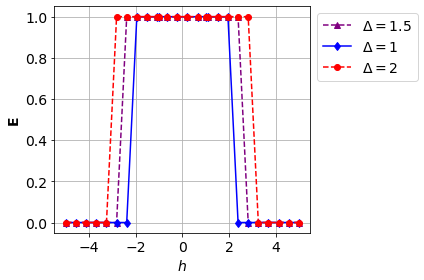

In [10]:
# Plot the results
plt.plot(p_values, optimal_values3, color='purple', linestyle='--', marker='^', label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_values2, 'b-d', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_values1, 'r--o', label=r"$\Delta=2$")  
plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()

# Figure 3

In [11]:
 # Rows entanglement
    
circuit, circuit_row, circuit_col, circuit_EO=create_qnode(NS)    

def overlap_row(psi, phi1, beta1, phi2, beta2, c1, c2, c3):
    state = circuit_row(phi1, beta1, phi2, beta2, c1, c2, c3, MR, NC)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_valuesR1 = []
optimal_valuesR2 = []
optimal_valuesR3 = []

# Perform hybrid optimization for each p
num_params = 7
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap_row) 
    optimal_valuesR1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap_row) 
    optimal_valuesR2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap_row) 
    optimal_valuesR3.append(best_overlap)
    

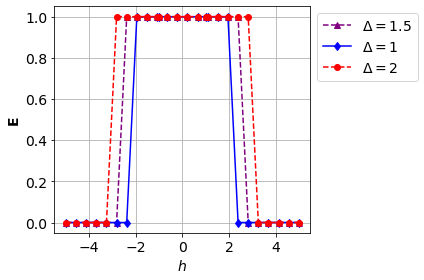

In [12]:
# Plot the results
plt.plot(p_values, optimal_valuesR3, color='purple', linestyle='--', marker='^',label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_valuesR2, 'b-d', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_valuesR1, 'r--o', label=r"$\Delta=2$")  
plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()

In [14]:

# Columns entanglement
    
circuit, circuit_row, circuit_col, circuit_EO=create_qnode(NS)    

def overlap_col(psi, phi1, beta1, phi2, beta2, c1, c2, c3):
    state = circuit_col(phi1, beta1, phi2, beta2, c1, c2, c3, MR, NC)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_valuesC1 = []
optimal_valuesC2 = []
optimal_valuesC3 = []

# Perform hybrid optimization for each p
num_params = 7
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap_col) 
    optimal_valuesC1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap_col) 
    optimal_valuesC2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap_col) 
    optimal_valuesC3.append(best_overlap)

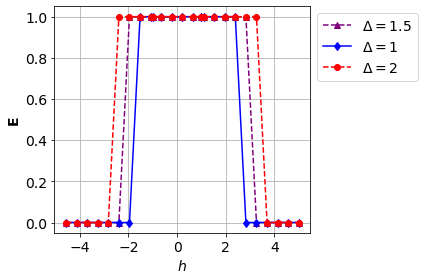

In [15]:
# Plot the results
plt.plot(p_values, optimal_valuesC3, color='purple', linestyle='--', marker='^',label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_valuesC2, 'b-d', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_valuesC1, 'r--o', label=r"$\Delta=2$")  
plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()

In [17]:
# Bipartite even-odd anglement
    
circuit, circuit_row, circuit_col, circuit_EO=create_qnode(NS)    

def overlap_EO(psi, phi1, beta1, phi2, beta2, c1, c2, c3):
    state = circuit_EO(phi1, beta1, phi2, beta2, c1, c2, c3, MR, NC)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_valuesEO1 = []
optimal_valuesEO2 = []
optimal_valuesEO3 = []

# Perform hybrid optimization for each p
num_params = 7
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO3.append(best_overlap)

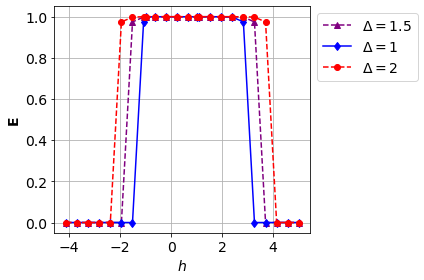

In [18]:
# Plot the results
plt.plot(p_values, optimal_valuesEO3, color='purple', linestyle='--', marker='^',label=r"$\Delta=1.5$")  
plt.plot(p_values, optimal_valuesEO2, 'b-d', label=r"$\Delta=1$")  
plt.plot(p_values, optimal_valuesEO1, 'r--o', label=r"$\Delta=2$")  
plt.xlabel(r"$h$", fontsize=14, fontweight='bold')
plt.ylabel("E", fontsize=14, fontweight='bold')

# Place the legend outside the plot
plt.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

# Adjust layout to avoid clipping of legend
plt.tight_layout()

plt.show()